# Background
This mini project will explore the [Bank Authentication Data Set](https://archive.ics.uci.edu/ml/datasets/banknote+authentication) from the UCI repository in order to perform a typical classification task using a simple deep neural network model (DNN) on TensorFlow. In order to investigate the effectiveness of DNN, a roughly constructed DNN model will be evaluated and compared to the highly-tuned logistic regression model by their accuracy.

From the authors:
>Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

The data consists of 5 columns:

* variance of Wavelet Transformed image (continuous)
* skewness of Wavelet Transformed image (continuous)
* curtosis of Wavelet Transformed image (continuous)
* entropy of image (continuous)
* class (integer)

Where `class` is the target variable that indicates whether or not a Bank Note was authentic.

# Libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Data overview

In [13]:
import pandas as pd

In [14]:
df = pd.read_csv('Data/bank_note_data.csv')

** Check the head of the Data **

In [15]:
df.head()

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# EDA
#### Distribution of the target variable

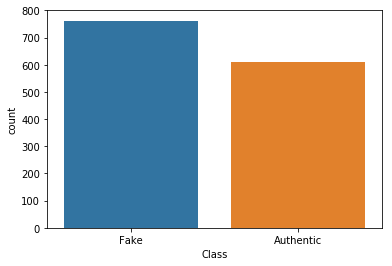

In [16]:
df_pp = df.copy()
df_pp['Class'] = np.where(df['Class']==0,'Fake','Authentic')
sns.countplot(df_pp['Class'])
plt.show()

#### Pairplot of the data by Class

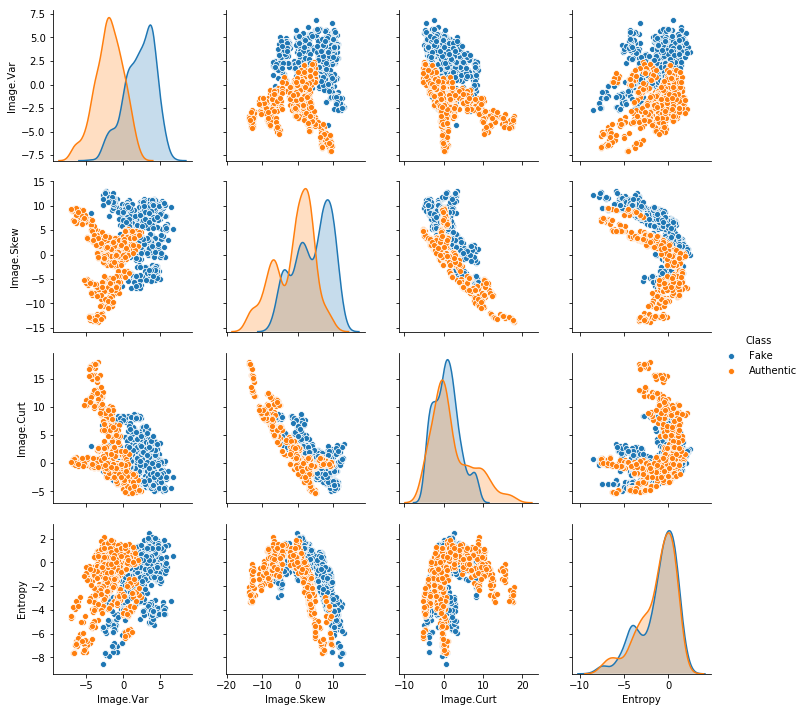

In [17]:
sns.pairplot(df_pp,hue='Class')
plt.show()

# Data preprocessing 
#### Train-test split and standarization

In [18]:
X = df.drop('Class',axis=1)
y = df['Class']

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)

In [21]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled,columns=X_train.columns)

# Model_1: Tensorflow DNN model construction
#### Creating a list of feature column objects

In [49]:
feat_cols = []
for col in X_train_scaled_df.columns:
    feat_cols.append(tf.feature_column.numeric_column(col))

#### Defining a classifier

In [58]:
classifier = tf.estimator.DNNClassifier(hidden_units=[10,10],n_classes=2,feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Sean\\AppData\\Local\\Temp\\tmphvgsnnpr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023BCA889198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Defining an input function

In [59]:
input_func = tf.estimator.inputs.pandas_input_fn(X_train,y_train,batch_size=20,shuffle=True)

#### Training a classifier with input function

In [60]:
classifier.train(input_fn=input_func,steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Sean\AppData\Local\Temp\tmphvgsnnpr\model.ckpt.
INFO:tensorflow:loss = 28.02778, step = 1
INFO:tensorflow:Saving checkpoints for 52 into C:\Users\Sean\AppData\Local\Temp\tmphvgsnnpr\model.ckpt.
INFO:tensorflow:Loss for final step: 0.032023825.


#### Evaluation

In [61]:
pred_func = tf.estimator.inputs.pandas_input_fn(X_test,batch_size=len(X_test),shuffle=False)

In [62]:
note_predictions = list(classifier.predict(input_fn=pred_func))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Sean\AppData\Local\Temp\tmphvgsnnpr\model.ckpt-52
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [63]:
final_preds = []
for pred in note_predictions:
    final_preds.append(pred['class_ids'][0])

In [64]:
pd.DataFrame(confusion_matrix(y_test,final_preds),columns=['Predicted Fake','Predicted Authentic'],index=['True Fake','Predicted Authentic'])

,Predicted Fake,Predicted Authentic
True Fake,198,0
Predicted Authentic,0,145


In [65]:
print(classification_report(y_test,final_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       198
           1       1.00      1.00      1.00       145

   micro avg       1.00      1.00      1.00       343
   macro avg       1.00      1.00      1.00       343
weighted avg       1.00      1.00      1.00       343



# Model_2: Highly tuned logistic regression

In [44]:
grid_param ={'C':[0.01,0.03,0.1,0.3,1,3,10,30]}
grid_lr = GridSearchCV(LogisticRegression(solver='lbfgs'),grid_param,cv=3,).fit(X_train,y_train)
print('best param: {}'.format(grid_lr.best_params_))
print('best score: {}'.format(grid_lr.best_score_))

best param: {'C': 1}
best score: 0.9922254616132167


In [45]:
y_predict_lr = grid_lr.predict(X_test)

In [47]:
pd.DataFrame(confusion_matrix(y_test,y_predict_lr),columns=['Predicted Fake','Predicted Authentic'],index=['True Fake','Predicted Authentic'])

,Predicted Fake,Predicted Authentic
True Fake,194,4
Predicted Authentic,0,145


In [48]:
print(classification_report(y_test,y_predict_lr))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       198
           1       0.97      1.00      0.99       145

   micro avg       0.99      0.99      0.99       343
   macro avg       0.99      0.99      0.99       343
weighted avg       0.99      0.99      0.99       343



# Conclsion
The explore dataset was turned out to be well separated intrinsically and basically any models would have great chance of achieivng high accuracy. While the training time was considerably longer, the DNN with randomly chosen hidden units and layers showed 100% prediction accuracy. On the other hand, more basic logistic regression model showed ~99% prediction accuracy where its regularization parameters were optimized through Grid Cross-validation search. This partially reflects the effectiveness of deep neural network, as in many fields, improving 1% prediction accuracy is highly desirable. 